# Data Visualization and Hyperparameter Tuning
The demo analyzing steel yield strengths includes t-SNE visualizations as well as a random forest model. These processes required tuning of hyperparameters (the perplexity for t-SNE, and number of decision trees for the random forest). Here, we experiment with tuning these parameters and finding values that give the clearest results. To make the demo simpler, we use this notebook to find these parameter values separately.
<br>

This notebook also includes an initial trial of PCA to visualize the data in lower dimensions, before moving on to try t-SNE for better clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import json

with open('steel_data.json') as file:
     j = json.load(file)

In [3]:
# get_properties(entry) returns a dictionary with (key, value) pairs as either:
# (element name, weight percent) or (yield stress, value in MPa).
# Requires: [entry] is one element (dictionary) from the steel data json file.
def get_properties(entry):
    d = {}
    comp = entry['composition'] # List of dictionaries with keys 'actualWeightPercent'
                                # and 'element'
    for e in comp:
        weight = e['actualWeightPercent']
        elem = e['element']
        d.update({elem : weight})

    prop_list = entry['properties']
    for prop in prop_list:
        if prop['name'] == 'Yield strength, YS':
           d.update({'YieldStrength' : prop['scalars']})
           break
    return d


In [4]:
data_dict = list(map(get_properties, j))
df = pd.DataFrame(data_dict)
df = df.applymap(lambda x: float(x))

compositions = df.drop('YieldStrength', axis=1).values
yield_strengths = df['YieldStrength'].values

print('The features of the data are: ', list(df))

The features of the data are:  ['Al', 'C', 'Co', 'Cr', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'Si', 'Ti', 'V', 'W', 'YieldStrength']


## Eigenvalue decomposition
Before attempting to visualize the 13-dimensional composition data, we can examine the eigenvalues of the composition's covariance matrix. The number of eigenvalues that are significantly larger than the rest give a hint as to the underlying dimensionality of the data. This can provide an estimate of PCA's ability to project the data onto 2 or 3 dimensions.

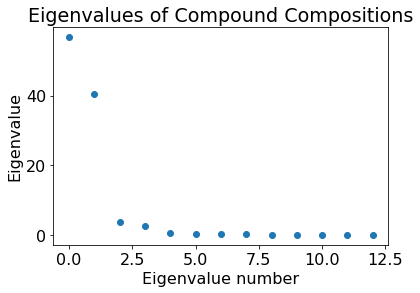

In [6]:
from scipy.linalg import eig
cov = np.cov(compositions.T) # Covariance of composition matrix
eig_vals = eig(cov)[0]

plt.scatter(range(len(eig_vals)), np.real(eig_vals))
plt.title('Eigenvalues of Compound Compositions')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue')
plt.show()


Since the two largest eigenvalues are significantly larger than the remaining 11, a 2-D projection would preserve distances fairly well. We can try running PCA to find this 2-D projection.

## PCA projection

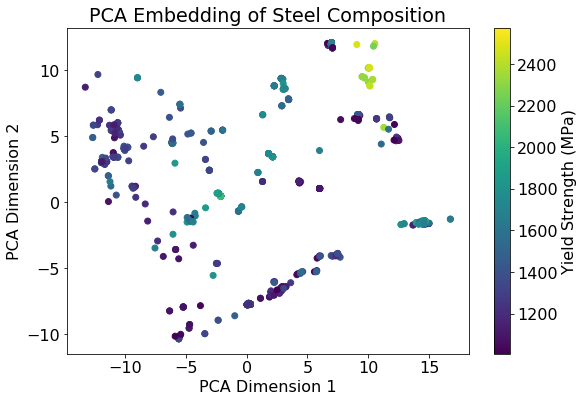

In [7]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
pca_embedding = pca_2d.fit_transform(compositions)

plt.figure(figsize=(9,6))
plt.scatter(pca_embedding[:,0], pca_embedding[:,1], c=yield_strengths)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.colorbar(label='Yield Strength (MPa)')
plt.title('PCA Embedding of Steel Composition')

plt.show()


While the PCA embedding did cluster steels of high yield strength relatively close together, we can still try t-SNE to see if we can get clearer clusters. The choice of perplexity for t-SNE can heavily impact the resulting graph. We try out a range of values between 5 and 60, and observe the effects.

## t-SNE perplexity tuning

Embedding with perplexity =  5


Embedding with perplexity =  10


Embedding with perplexity =  15


Embedding with perplexity =  20


Embedding with perplexity =  25


Embedding with perplexity =  30


Embedding with perplexity =  40


Embedding with perplexity =  50


Embedding with perplexity =  60


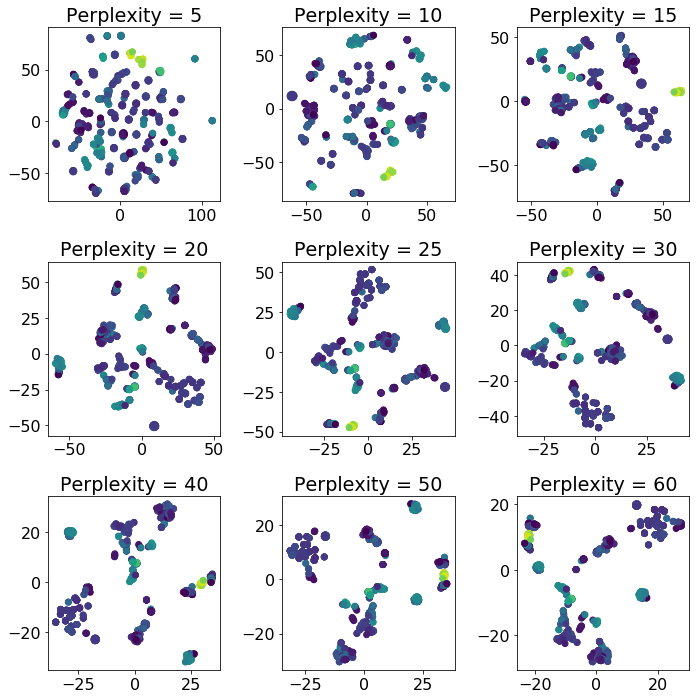

In [8]:
from sklearn.manifold import TSNE

fig, axes = plt.subplots(3, 3, figsize = (10,10))
perplexities = [5, 10, 15, 20, 25, 30, 40, 50, 60]

for i, ax in enumerate(axes.flatten()):
    perp = perplexities[i]
    print('Embedding with perplexity = ', perp)
    
    embedding = TSNE(n_components=2, perplexity=perp).fit_transform(compositions)
    xs = embedding[:,0]
    ys = embedding[:,1]
    ax.scatter(xs, ys, c=yield_strengths)
    ax.set_title('Perplexity = ' + str(perp))

plt.tight_layout()
plt.savefig('Perplexity_ranges')
plt.show()

As we can see, raising the perplexity past 25 does not have a significant effect on the clarity of the clusters. For simplicity, we choose 25 for the perplexity in the corresponding demo.
<br>

## Random forest: number of trees
In the demo, we use a random forest model to predict yield strengths and analyze feature importances. The hyperparameter we need to tune here is the number of decision trees used in the model. The dataset has only 13 features, yet there are not too many samples, so we try out a range of values larger than the default of 10 estimators.
<br>

We use Scikit-learn's grid search to test out a range of decision tree numbers. We can plot the mean scores of the model on a test set and observe how it changes as we increase the number of trees.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         compositions, yield_strengths, test_size=0.2, random_state=42)
         

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state = 42)
params = {'n_estimators' : [10, 50, 100, 250, 500]}
grid = GridSearchCV(rfr, params)
grid.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

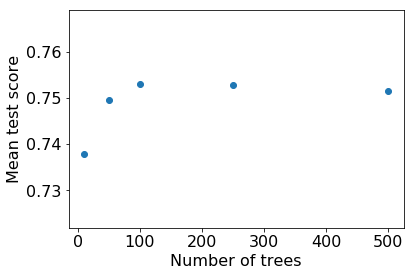

In [11]:
scores = grid.cv_results_['mean_test_score']
trees = params['n_estimators']

plt.xlabel('Number of trees')
plt.ylabel('Mean test score')
plt.savefig('Num_trees')
plt.scatter(trees, scores)
plt.show()


The mean test score appears to plateau around 100 trees in the random forest model. As a result, we choose 100 for the number of trees in the random forest model for the demo.